In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import bgreat

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
data = pd.read_csv("../data/example/CD_data.csv",index_col=0)
meta = pd.read_csv("../data/example/CD_meta.csv")

In [5]:
data.head()

,1,2,3,4,5,6,7,8,10,11,...,103,104,105,106,107,108,110,111,112,113
time,,,,,,,,,,,,,,,,,,,,,
0.0,0.097,0.094,0.093,0.089,0.090,0.090,0.090,0.096,0.096,0.093,...,0.093,0.099,0.099,0.099,0.098,0.099,0.099,0.097,0.093,0.091
0.5,0.097,0.096,0.095,0.090,0.090,0.090,0.091,0.096,0.096,0.093,...,0.092,0.100,0.100,0.101,0.098,0.098,0.097,0.095,0.092,0.091
1.0,0.099,0.098,0.096,0.091,0.092,0.091,0.093,0.098,0.098,0.094,...,0.094,0.103,0.104,0.103,0.100,0.100,0.099,0.097,0.094,0.093
1.5,0.099,0.097,0.096,0.091,0.091,0.091,0.093,0.098,0.099,0.095,...,0.093,0.103,0.103,0.103,0.100,0.100,0.099,0.097,0.094,0.092
2.0,0.101,0.099,0.098,0.092,0.092,0.091,0.095,0.099,0.101,0.096,...,0.095,0.104,0.104,0.104,0.100,0.101,0.100,0.099,0.095,0.093


In [6]:
meta.head()

,strain,Condition
0,ura3_EV,control
1,ura3_EV,control
2,ura3_EV,control
3,ura3_EV,control
4,ura3_EV,control


In [9]:
assert data.shape[1] == meta.shape[0]

In [10]:
parent = 'ura3_EV'
control = 'control'
condition = 'stress'

meta['strain-regression'] = (meta.strain!=parent).astype(int)
meta['condition'] = (meta.Condition!=control).astype(int)
meta['interaction'] = meta['strain-regression']*meta.condition

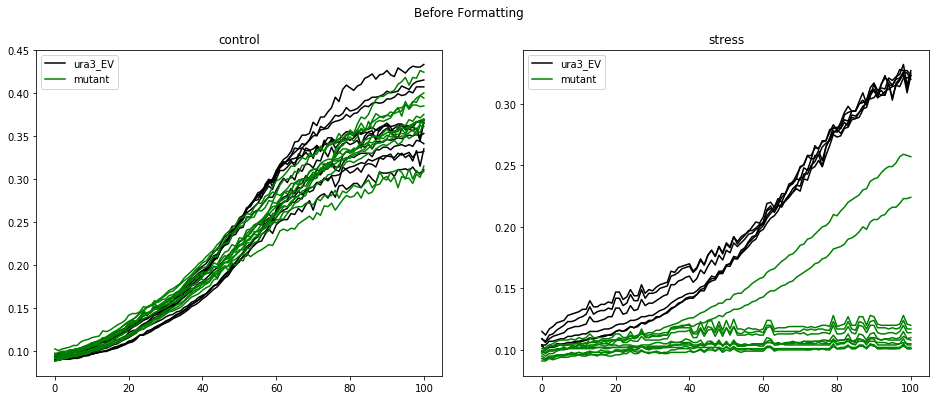

In [11]:
plt.figure(figsize=(16,6))
plt.suptitle("Before Formatting")

plt.subplot(121)
plt.title('control')
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain==parent))[0]],color='k',label=parent)
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
# plt.ylim(0.05,.7)

plt.subplot(122)
plt.title('stress')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain==parent))[0]],color='k',label=parent)
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
# plt.ylim(0.05,.7)

## Formatting data

Required:
* time column should be a numeric type

Optional:
* log data
* subtract first time point
* remove early time points

In [12]:
# remove the first four time points

data = data.iloc[4:,:]

In [13]:
# data.index = np.arange(0,data.shape[0]*.5,.5)

In [14]:
# log the data and subtract the first timepoint
data = np.log2(data)

# data = data-data.iloc[0,:].values

In [15]:
g = meta.groupby(['strain','Condition'])

In [16]:
for k,ind in g.groups.iteritems():
    print k
    
    data.iloc[:,ind] -= data.iloc[0,ind].mean()

('rosR_EV', 'control')
('ura3_EV', 'control')
('rosR_EV', 'stress')
('ura3_EV', 'stress')


(-0.4, 2.4)

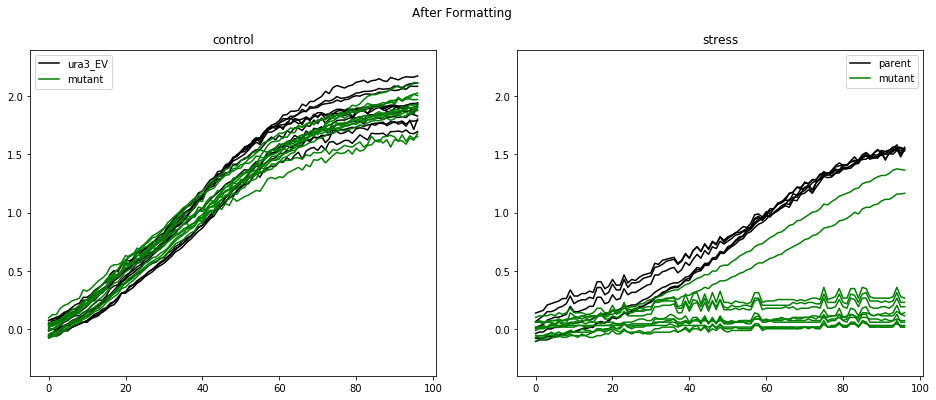

In [17]:
plt.figure(figsize=(16,6))
plt.suptitle("After Formatting")

plt.subplot(121)
plt.title('control')
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain==parent))[0]],color='k',label=parent)
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(-.4,2.4)

plt.subplot(122)
plt.title('stress')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain==parent))[0]],color='k',label='parent')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(-.4,2.4)

## B-GREAT globals

B-GREAT has a number of global variables that must be set before analysis. Setting these variables is done with the `setGlobals` method, by specifying the matching variable name with an '\_' prefix, e.g. `\_data` for the `data` variable. Briefly, the globals are:

* `data`: The data matrix used in this study
* `meta`: meta data associated with the data matrix, the numbers of columns in `data` should match the number of rows in `meta`
* `parent`: the name of the parent strain which will be tested against all other strains
* `control`: the control condition in the data, if applicable
* `condition`: the non-control condition to test, if applicable

In [18]:
import bgreat
bgreat.setGlobals(_data=data,_meta=meta)

bgreat.setGlobals(_parent=parent,_control=control)

## B-GREAT Analysis

### Analysis methods:

* `testMutantControl`: test mutant strain growth under the control condition
* `testMutantCondition`: test mutant strain growth under the non-control condition, conditioned on the control data

### Parameters:

* `numPerm`: the number of null permutations to perform for false discovery rate calculations
* `timeThin`: step size in selecting time-points for training the model

### Output:

* `actual`: actual Bayes factor (BF) score, representing the ratio of data likelihood when strain (or interaction) information is taken into account, e.g. $p(Y| H_a) / p(Y | H_0)$. Value is log of BF score.
* `permuted`: BF scores calculated when permuting the input in order to test the significance of the actual BF
* `FDR`: false discovery rate of the BF

#### control

In [57]:
bgreat.setGlobals(_data=data,_meta=meta,_parent=parent,_control=control,_condition=None)

In [58]:
mutants = ['rosR_EV']
results = bgreat.testMutantControl(mutants,numPerm=20,dims=['time','strain-regression'])

results

,actual,permuted,FDR
rosR_EV,25.73021,"[2.63329594359, 14.1125276394, -6.9587460132e-...",0.15


(array([ 12.,   3.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([ -8.35771503e-05,   7.05955866e+00,   1.41192009e+01,
          2.11788431e+01,   2.82384854e+01,   3.52981276e+01,
          4.23577699e+01,   4.94174121e+01,   5.64770544e+01,
          6.35366966e+01,   7.05963388e+01]),
 <a list of 10 Patch objects>)

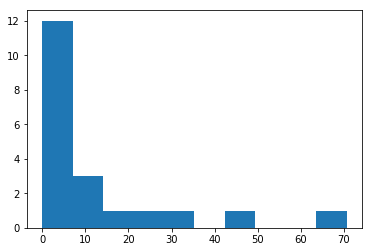

In [62]:
plt.hist(results.permuted.values[0])

#### stress 

In [63]:
bgreat.setGlobals(_condition=condition)

In [ ]:
mutants = ['rosR_EV']
results = bgreat.testMutantCondition(mutants,numPerm=10)

results

### Further analysis 

#### Control

In [33]:
bgreat.condition = None
gp = bgreat.buildGP(bgreat.selectStrain('rosR_EV'))

In [34]:
gp

GP_regression.,value,constraints,priors
mul.rbf.variance,0.967235196356,+ve,
mul.rbf.lengthscale,18.9172949397,+ve,
mul.rbf_1.variance,0.967235196433,+ve,
mul.rbf_1.lengthscale,5.73094577214,+ve,
Gaussian_noise.variance,0.0106402259217,+ve,


In [35]:
xpred = np.zeros((100,2))
xpred[:50,0] = np.linspace(data.index.min(),data.index.max())
xpred[50:,0] = np.linspace(data.index.min(),data.index.max())

xpred[50:,1] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

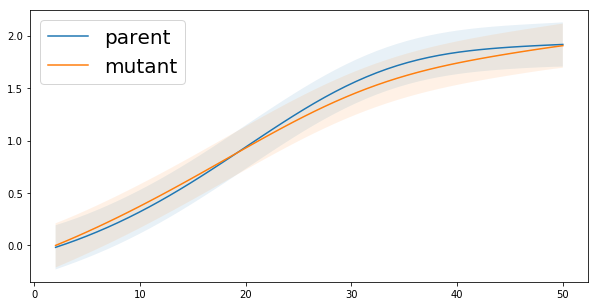

In [36]:
plt.figure(figsize=(10,5))

plt.plot(xpred[:50,0],mu[:50],label='parent');
plt.fill_between(xpred[:50,0],mu[:50]-2*np.sqrt(var[:50]),mu[:50]+2*np.sqrt(var[:50]),alpha=.1)

plt.plot(xpred[:50,0],mu[50:],label='mutant')
plt.fill_between(xpred[:50,0],mu[50:]-2*np.sqrt(var[50:]),mu[50:]+2*np.sqrt(var[50:]),alpha=.1)

plt.legend(fontsize=20)

In [37]:
op = np.zeros((50,100))
op[np.arange(50),np.arange(50)] = -1
op[np.arange(50),np.arange(50)+50] = 1

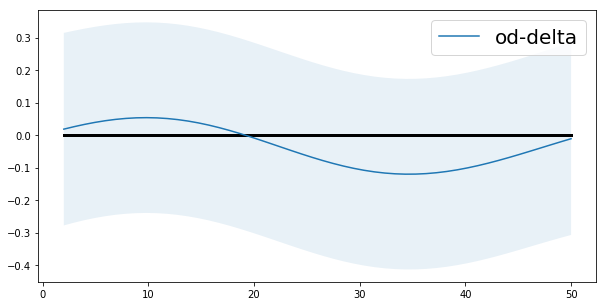

In [38]:
oddeltaMu = np.dot(op,mu)
oddeltaCov = np.dot(np.dot(op,cov),op.T)
oddeltaVar = np.diag(oddeltaCov)

plt.figure(figsize=(10,5))
plt.plot([data.index.min(),data.index.max()],[0,0],'k',lw=3)
plt.plot(xpred[:50,0],oddeltaMu,label='od-delta')
plt.fill_between(xpred[:50,0],oddeltaMu-2*np.sqrt(oddeltaVar),oddeltaMu+2*np.sqrt(oddeltaVar),alpha=.1)
plt.legend(fontsize=20)

####  Stress

In [39]:
bgreat.condition = 'stress'
gp = bgreat.buildGP(bgreat.selectStrain('rosR_EV'),dims=['condition','interaction'])

In [40]:
gp

GP_regression.,value,constraints,priors
mul.rbf.variance,0.294037942156,+ve,
mul.rbf.lengthscale,27.0812857065,+ve,
mul.sum.rbf.variance,0.533054546998,+ve,
mul.sum.rbf.lengthscale,3.99681229931,+ve,
mul.sum.rbf_1.variance,0.500077112732,+ve,
mul.sum.rbf_1.lengthscale,0.463398303082,+ve,
mul.sum.rbf_2.variance,0.714483757979,+ve,
mul.sum.rbf_2.lengthscale,0.279931717641,+ve,
Gaussian_noise.variance,0.0237152747248,+ve,


In [41]:
xpred = np.zeros((200,4))
xpred[:,0] = np.tile(np.linspace(data.index.min(),data.index.max()),4)
xpred[100:,1] = 1
xpred[50:100,2] = 1
xpred[150:,2] = 1
xpred[150:,3] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

In [42]:
# plt.figure(figsize=(10,5))

# parentSlice = slice(0,50)
# mutantSlice = slice(100,150)

# plt.plot(xpred[parentSlice,0],mu[parentSlice],label='parent');
# plt.fill_between(xpred[:50,0],mu[parentSlice]-2*np.sqrt(var[parentSlice]),mu[parentSlice]+2*np.sqrt(var[parentSlice]),alpha=.1)

# plt.plot(xpred[:50,0],mu[mutantSlice],label='mutant')
# plt.fill_between(xpred[mutantSlice,0],mu[mutantSlice]-2*np.sqrt(var[mutantSlice]),mu[mutantSlice]+2*np.sqrt(var[mutantSlice]),alpha=.1)

# plt.legend(fontsize=20)

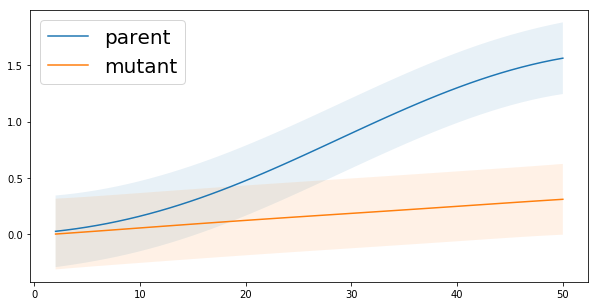

In [43]:
plt.figure(figsize=(10,5))

parentSlice = slice(50,100)
mutantSlice = slice(150,200)

plt.plot(xpred[parentSlice,0],mu[parentSlice],label='parent');
plt.fill_between(xpred[:50,0],mu[parentSlice]-2*np.sqrt(var[parentSlice]),mu[parentSlice]+2*np.sqrt(var[parentSlice]),alpha=.1)

plt.plot(xpred[:50,0],mu[mutantSlice],label='mutant')
plt.fill_between(xpred[mutantSlice,0],mu[mutantSlice]-2*np.sqrt(var[mutantSlice]),mu[mutantSlice]+2*np.sqrt(var[mutantSlice]),alpha=.1)

plt.legend(fontsize=20)

In [44]:
op = np.zeros((50,200))
op[np.arange(50),np.arange(50)+50] = -1
op[np.arange(50),np.arange(50)+150] = 1

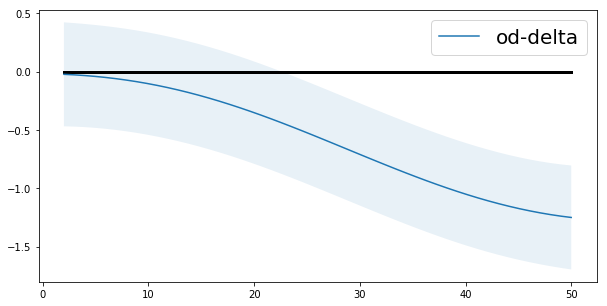

In [45]:
oddeltaMu = np.dot(op,mu)
oddeltaCov = np.dot(np.dot(op,cov),op.T)
oddeltaVar = np.diag(oddeltaCov)

plt.figure(figsize=(10,5))
plt.plot([data.index.min(),data.index.max()],[0,0],'k',lw=3)
plt.plot(xpred[:50,0],oddeltaMu,label='od-delta')
plt.fill_between(xpred[:50,0],oddeltaMu-2*np.sqrt(oddeltaVar),oddeltaMu+2*np.sqrt(oddeltaVar),alpha=.1)
plt.legend(fontsize=20)

plt.savefig("test.png")

In [54]:
xpred = np.zeros((150,4))
xpred[:,0] = np.tile(np.linspace(data.index.min(),data.index.max()),3)
xpred[50:,1] = 1
xpred[:,2] = 1
xpred[100:,3] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

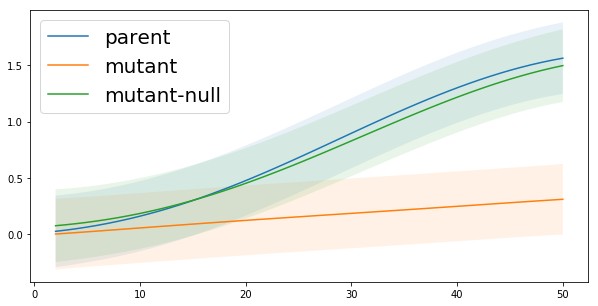

In [55]:
plt.figure(figsize=(10,5))

parentSlice = slice(0,50)
mutantSliceNull = slice(50,100)
mutantSlice = slice(100,150)

plt.plot(xpred[parentSlice,0],mu[parentSlice],label='parent');
plt.fill_between(xpred[:50,0],mu[parentSlice]-2*np.sqrt(var[parentSlice]),mu[parentSlice]+2*np.sqrt(var[parentSlice]),alpha=.1)

plt.plot(xpred[:50,0],mu[mutantSlice],label='mutant')
plt.fill_between(xpred[mutantSlice,0],mu[mutantSlice]-2*np.sqrt(var[mutantSlice]),mu[mutantSlice]+2*np.sqrt(var[mutantSlice]),alpha=.1)

plt.plot(xpred[:50,0],mu[mutantSliceNull],label='mutant-null')
plt.fill_between(xpred[mutantSliceNull,0],mu[mutantSliceNull]-2*np.sqrt(var[mutantSliceNull]),mu[mutantSliceNull]+2*np.sqrt(var[mutantSliceNull]),alpha=.1)

plt.legend(fontsize=20)